Production (Importing, Functions, Creating Features, Flipping Values, Feature Analysis & Selection, Exporting)

In [627]:
# Import Libraries and Data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 300)

import seaborn as sns
import matplotlib.pyplot as plt

# Import Data (NOT CURRENT YEAR)
df = pd.read_csv("../data/pipeline/merged_team_season.csv")

# Create Features, Including Difference and Ratio Columns
def calculate_diff_ratio_pythag(df: pd.DataFrame, features = [str], diff_ratio_pythag: str = 'difference'):
    for feature in features:

        # Find Difference, Ratio, or Pythagorean of A Feature Between The Two Teams
        if diff_ratio_pythag == 'difference':
            df[f'{feature}_diff'] = df[f'team1_{feature}'] - df[f'team2_{feature}']
        elif diff_ratio_pythag == 'ratio':
            df[f'{feature}_ratio'] = df[f'team1_{feature}'] / df[f'team2_{feature}']   
        elif diff_ratio_pythag == 'pythag':
            df['team1_pythag'] = (df[f'team1_{feature}'] - (df[f'team1_{feature}']*df[f'team2_{feature}']))/ (df[f'team1_{feature}'] + df[f'team2_{feature}']-(2*df[f'team1_{feature}']*df[f'team2_{feature}']))
    return df

# Flips DF2 Differences and Ratios
def flip_df2_diff_ratio_pythag(df: pd.DataFrame, feature_dict: dict):
    
    # Loop Through Difference and Ratio, Apply Appropriate Transformation
    for diff_ratio_pythag in list(feature_dict.keys()):
        for feat in feature_dict[diff_ratio_pythag]:
            
            if diff_ratio_pythag == 'diff':
                df[f'{feat}_diff'] = df[f'{feat}_diff'] * -1
            elif diff_ratio_pythag == 'ratio':
                df[f'{feat}_ratio'] = 1 / df[f'{feat}_ratio']
            elif diff_ratio_pythag == 'pythag':
                df[f'team1_{diff_ratio_pythag}'] = 1 - df[f'team1_{diff_ratio_pythag}']
                
    # Change Team1 Win, Score, and Game ID
    df['team1_win'] = 0
    t1s, t2s = df['team1_score'], df['team2_score']
    df['team1_score'], df['team2_score'] = t2s, t1s
    df['game_id'] = (df['game_id'].str.split('-', expand=True)[0] + '-' + df['game_id'].str.split('-', expand=True)[2] + '-' + df['game_id'].str.split('-', expand=True)[1])
    
    return df

In [628]:
# Choose Season Cutoff and Features
# df = df[df['season'] >= 2008]

# Creat List of Features For Ratios
features_ratio = []
for item in list(df.columns):
    if 'team1_' in item or 'team2_' in item:
        features_ratio.append(item[6:])
features_ratio = list(set(features_ratio))

# Drop Irrelevant Features
features_ratio = [feat for feat in features_ratio if feat not in ['rd', 'coach_id', 'team_id', 'id','score', 'seed', 'type', 
                                                                  'teamname', 'games_above_500', 'q1_w','q3q4_l', 'q2_w']]

# Calculate Differences, Ratios, and Pythag Between Features
features = {'diff': ['seed'],
            'ratio': features_ratio,
            'pythag': ['exp_win']}

# Calculate Pythagorean W/L Based On Adjusted Offensive Efficiency
df['team1_exp_win'] = (df['team1_adjoe']**11.5)/ ((df['team1_adjde']**11.5)+(df['team1_adjoe']**11.5))
df['team2_exp_win'] = (df['team2_adjoe']**11.5)/ ((df['team2_adjde']**11.5)+(df['team2_adjoe']**11.5))

In [629]:
# Calculate Team Differences, Ratios, and Pythag
df = calculate_diff_ratio_pythag(df, features['diff'], diff_ratio_pythag = 'difference')
df = calculate_diff_ratio_pythag(df, features['ratio'], diff_ratio_pythag = 'ratio')
df = calculate_diff_ratio_pythag(df, features['pythag'], diff_ratio_pythag = 'pythag')

# Establish Training Columns
standard_training_columns = ['game_id','season','team1_win','team1_score','team2_score']
feature_columns = [col for col in df.columns if 'diff' in col or 'ratio' in col or 'pythag' in col]
training_columns = standard_training_columns + feature_columns

#Create a team 1 win column to determine which rows actually have them winning
df['team1_win'] = (df['team1_score'] > df['team2_score']).astype(int)

# Randomly Select Games To Place in Df 1 and Rest in Df 2
df_1 = df.sample(frac=.5, random_state=15)[training_columns].reset_index(drop=True)
df_2 = df[~df.index.isin(df_1.index)][training_columns].reset_index(drop=True)

# In Second Df, Flip The Attributes
df_2 = flip_df2_diff_ratio_pythag(df_2, features)

#Combine DataFrames, Create 2019 Holdout Set
df = pd.concat([df_1, df_2]).reset_index(drop=True)

In [630]:
# Inspect Correlation and Influence on Team 1 Winning

# Get All Diffs, Ratio, and Pythag
complete_ratio_cols = [col + '_ratio' for col in features_ratio]
complete_ratio_cols.append('team1_pythag')
complete_ratio_cols.remove('team_score_ratio')

# Normalize Features For Fair Comparison
scaler = StandardScaler()
df_cols_to_norm = df[complete_ratio_cols]
df_cols_to_norm = df_cols_to_norm.fillna(df_cols_to_norm.mean())
df_norm = pd.DataFrame(scaler.fit_transform(df_cols_to_norm), columns = complete_ratio_cols)
df_norm = pd.concat([df_norm, df['team1_win']], axis = 1)

# Compare Biggest Mean Difference When Team 1 Wins and Losses
mean_values_0 = df_norm[df_norm['team1_win'] == 0][complete_ratio_cols].mean()
mean_values_1 = df_norm[df_norm['team1_win'] == 1][complete_ratio_cols].mean()
team1_win_change = pd.DataFrame(abs(mean_values_1 - mean_values_0).sort_values(ascending=False), columns = ['team1_win_difference'])

# Show Corrleation To Team1 Pythag, The Strongest Indicator
team1_pythag = df_norm[complete_ratio_cols].corr(method='spearman')
team1_pythag = pd.DataFrame(abs(team1_pythag['team1_pythag']))

# View Them Together
win_and_pythag = pd.merge(team1_win_change, team1_pythag, left_index = True, right_index = True, how = 'inner')
win_and_pythag['win_difference_minus_pythag_corr'] = win_and_pythag['team1_win_difference'] - win_and_pythag['team1_pythag']
win_and_pythag[(win_and_pythag['team1_win_difference'] > .15) & (win_and_pythag['win_difference_minus_pythag_corr'] > -.1)].sort_values(by = 'team1_win_difference', ascending=False)

,team1_win_difference,team1_pythag,win_difference_minus_pythag_corr
team1_pythag,0.958494,1.000000,-0.041506
adjoe_ratio,0.772663,0.728907,0.043757
adjde_ratio,0.675595,0.734499,-0.058904
oe_ratio,0.654028,0.546585,0.107443
home_badj d_ratio,0.460087,0.445897,0.014190
de_ratio,0.446779,0.508870,-0.062092
away_badj o_ratio,0.437982,0.416027,0.021956
away_badj d_ratio,0.400487,0.480037,-0.079551
fg2pct_ratio,0.386939,0.374316,0.012623
oppfg2pct_ratio,0.384562,0.444990,-0.060428


Total Correlation Overlap: 2.05


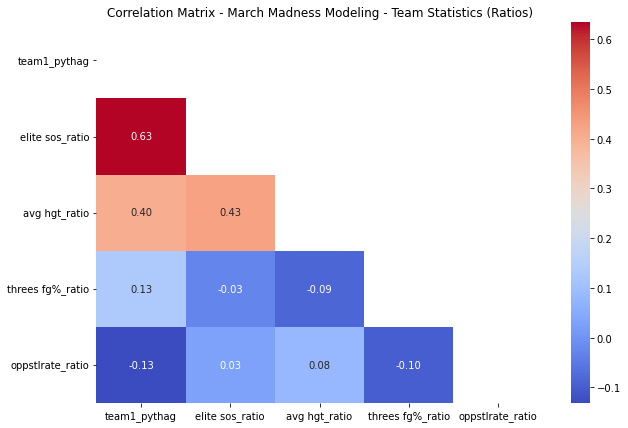

In [631]:
# Produce Correlation Matrix and Correlation Sum
final_features = ['team1_pythag', 'elite sos_ratio', 'avg hgt_ratio', 'threes fg%_ratio', 'oppstlrate_ratio']

corr_matrix = df[final_features].corr(method='spearman')
print('Total Correlation Overlap:', round((abs(corr_matrix).sum().sum() - len(corr_matrix))/2,2))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask = mask)
plt.title('Correlation Matrix - March Madness Modeling - Team Statistics (Ratios)')
plt.show()

In [632]:
# Export Training Data
df = df[standard_training_columns + final_features]
# df= df.fillna(df.mean())

df.to_csv("../data/pipeline/train.csv", index = False)
df.describe()

,season,team1_win,team1_score,team2_score,team1_pythag,elite sos_ratio,avg hgt_ratio,threes fg%_ratio,oppstlrate_ratio
count,1380.000000,1380.000000,1380.00000,1380.000000,1380.000000,796.000000,796.000000,602.000000,1380.000000
mean,2010.223188,0.500000,69.86087,69.559420,0.508200,1.304769,1.002000,1.010330,1.018868
std,6.261133,0.500181,11.96512,12.183041,0.233821,0.819313,0.016295,0.100889,0.189809
min,2002.000000,0.000000,29.00000,34.000000,0.011894,0.254059,0.956814,0.770833,0.547842
25%,2005.000000,0.000000,61.00000,61.000000,0.330735,0.807837,0.990825,0.941258,0.887508
50%,2009.000000,0.500000,70.00000,70.000000,0.506609,1.061650,1.001491,1.000000,1.003123
75%,2015.000000,1.000000,78.00000,77.000000,0.689072,1.574506,1.013043,1.070466,1.132657
max,2023.000000,1.000000,111.00000,121.000000,0.987418,6.049554,1.070694,1.467128,1.878425
